In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

# Set a random seed for reproducibility
torch.manual_seed(42)

In [2]:
# Example sentence from the slides
#Input: sentence
#Output: dictory for each word in the sentence
example_sentence = "Tom is planning to visit Tokyo Tower and he will buy some gifts"

# First, let's create a simple tokenizer and vocabulary
def build_vocab(text):
    words = text.lower().split()
    vocab = {word: i+1 for i, word in enumerate(sorted(set(words)))}
    vocab['<pad>'] = 0  # Add padding token
    return vocab, {i: w for w, i in vocab.items()}

vocab, idx_to_word = build_vocab(example_sentence.lower())
print("Vocabulary:", vocab)

Vocabulary: {'and': 1, 'buy': 2, 'gifts': 3, 'he': 4, 'is': 5, 'planning': 6, 'some': 7, 'to': 8, 'tokyo': 9, 'tom': 10, 'tower': 11, 'visit': 12, 'will': 13, '<pad>': 0}


In [3]:
# Convert the sentence to indices
#Input: sentence, dictory(vocab)
#Output: Tokenized sentence
def tokenize(text, vocab):
    return [vocab[word.lower()] for word in text.split()]

tokenized_sentence = tokenize(example_sentence, vocab)
print("Tokenized sentence:", tokenized_sentence)


Tokenized sentence: [10, 5, 6, 8, 12, 9, 11, 1, 4, 13, 2, 7, 3]


In [15]:
# Create a simple dataset for demonstration
# It implements the required methods of PyTorch's Dataset class:
class TextDataset(Dataset):
    def __init__(self, sentences, vocab, max_len=None):
        self.vocab = vocab
        if isinstance(sentences, str):
            sentences = [sentences]

        # Tokenize all sentences
        self.data = [tokenize(sent, vocab) for sent in sentences]

        # Find max length if not provided
        if max_len is None:
            max_len = max(len(s) for s in self.data)
        self.max_len = max_len

        # Pad sequences
        for i in range(len(self.data)):
            if len(self.data[i]) < self.max_len:
                self.data[i] = self.data[i] + [vocab['<pad>']] * (max_len - len(self.data[i]))
            else:
                self.data[i] = self.data[i][:max_len]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.long)


In [16]:
    dataset = TextDataset(example_sentence, vocab)
    text_tensor = dataset[0] # there is only one sentence, so only index 0 has element. try dataset[1], we would get an index error
    print(dataset)
    print(text_tensor)

tensor([10,  5,  6,  8, 12,  9, 11,  1,  4, 13,  2,  7,  3])


In [17]:
# Function to highlight long-term dependencies
def visualize_dependencies(text, first_word, second_word):
    tokens = text.split()

    # Find positions
    first_pos = tokens.index(first_word)
    second_pos = tokens.index(second_word)

    # Create colors
    colors = ['white'] * len(tokens)
    colors[first_pos] = 'orange'
    colors[second_pos] = 'orange'

    # Create the plot
    plt.figure(figsize=(12, 2))
    for i, (token, color) in enumerate(zip(tokens, colors)):
        plt.text(i, 0, token, ha='center', va='center',
                 bbox=dict(facecolor=color, alpha=0.3))

    # Add an arrow
    plt.annotate('', xy=(second_pos, 0.2), xytext=(first_pos, 0.2),
                arrowprops=dict(arrowstyle='<->', color='red'))

    plt.xlim(-0.5, len(tokens) - 0.5)
    plt.ylim(-0.5, 0.5)
    plt.axis('off')
    plt.title(f"Long-term dependency between '{first_word}' and '{second_word}'")
    plt.show()


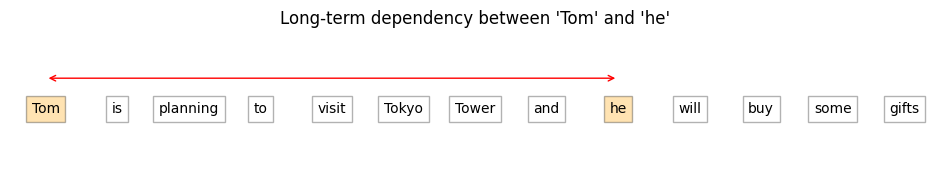

In [18]:
    # Visualize the original dependency
    visualize_dependencies(example_sentence, "Tom", "he")

In [38]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_filters, filter_sizes, output_dim):
        super(TextCNN, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # Create convolutional layers with different filter sizes
        self.convs = nn.ModuleList([
            nn.Conv1d(embedding_dim, num_filters, fs)
            for fs in filter_sizes
        ])

        # Fully connected layer for prediction
        self.fc = nn.Linear(len(filter_sizes) * num_filters, output_dim)

        # Track the intermediates for visualization
        self.intermediate_features = {}

    def forward(self, text, store_intermediates=False):
        # text shape: [batch_size, seq_len]

        # Get embeddings and transpose for conv1d
        # embedded shape after transpose: [batch_size, embedding_dim, seq_len]
        embedded = self.embedding(text).permute(0, 2, 1)

        # Apply convolutions
        # conv_out shape for each conv: [batch_size, num_filters, seq_len - filter_size + 1]
        conv_outputs = []
        for i, conv in enumerate(self.convs):
            conv_out = nn.functional.relu(conv(embedded))

            # Store intermediates if needed for visualization
            if store_intermediates:
                self.intermediate_features[f'conv_{i}'] = conv_out.detach().clone()

            # Global max pooling
            # pooled shape: [batch_size, num_filters]
            pooled = nn.functional.max_pool1d(conv_out, conv_out.shape[2]).squeeze(2)
            conv_outputs.append(pooled)

        # Concatenate outputs from different filter sizes
        # cat shape: [batch_size, num_filters * len(filter_sizes)]
        cat = torch.cat(conv_outputs, dim=1)

        # Final prediction
        return self.fc(cat)

    def get_feature_maps(self, text):
        # Reset stored features
        self.intermediate_features = {}

        # Forward pass with intermediate feature storage
        _ = self.forward(text, store_intermediates=True)

        return self.intermediate_features


In [39]:
  # Set parameters
VOCAB_SIZE = len(vocab)
EMBEDDING_DIM = 50
NUM_FILTERS = 3
FILTER_SIZES = [3, 5, 7]  # Different window sizes
OUTPUT_DIM = 2  # Just for demonstration

# Create model
model = TextCNN(VOCAB_SIZE, EMBEDDING_DIM, NUM_FILTERS, FILTER_SIZES, OUTPUT_DIM)
# Print model architecture
print("\nModel Architecture:")
print(model)



Model Architecture:
TextCNN(
  (embedding): Embedding(14, 50)
  (convs): ModuleList(
    (0): Conv1d(50, 3, kernel_size=(3,), stride=(1,))
    (1): Conv1d(50, 3, kernel_size=(5,), stride=(1,))
    (2): Conv1d(50, 3, kernel_size=(7,), stride=(1,))
  )
  (fc): Linear(in_features=9, out_features=2, bias=True)
)


In [40]:
# Print detailed processing results for each layer
print("Detailed Layer-by-Layer Processing Results:")

# Get embeddings
embedded = model.embedding(text_tensor.unsqueeze(0)).permute(0, 2, 1)
print(f"\nEmbedding Layer Output: shape {embedded.shape}")

print(f"Embedding for 'Tom':")
tom_idx = text_tensor[0].item()
print(f"Word 'Tom' has index {tom_idx}")
print(model.embedding(torch.tensor([tom_idx])))

print(f"Embedding for 'he':")
he_idx = text_tensor[8].item()
print(f"Word 'he' has index {he_idx}")
print(model.embedding(torch.tensor([he_idx])))

Detailed Layer-by-Layer Processing Results:

Embedding Layer Output: shape torch.Size([1, 50, 13])
Embedding for 'Tom':
Word 'Tom' has index 10
tensor([[-0.3881,  1.2434,  1.2517, -0.4343, -0.0862, -0.8530,  0.7811, -0.3048,
          2.5861, -0.2113, -0.7511,  1.2406, -0.9439, -0.1740, -1.1805, -0.9256,
          0.6257, -0.4383,  1.4853, -2.3831, -1.4559,  1.0205, -1.2219, -0.1771,
         -0.2709, -1.5133, -0.7397, -0.5664,  0.4003, -0.3848,  2.4440,  1.1740,
         -1.4091, -0.3466, -0.8531,  0.7476,  0.3124, -0.4985, -0.2789,  2.1277,
         -0.3430, -0.4346,  1.8118, -1.3781,  1.6818, -2.8821,  0.1810,  0.2857,
         -1.9508, -0.5830]], grad_fn=<EmbeddingBackward0>)
Embedding for 'he':
Word 'he' has index 4
tensor([[-0.1578, -0.7461, -1.2852,  0.2910, -1.1830,  2.1551,  1.9602, -0.5440,
          1.5822, -1.0451,  1.9725,  0.1989, -0.0427,  0.3994, -3.0429, -0.9100,
         -1.0403, -0.3188, -1.5931, -1.6859,  1.6516, -2.1345, -0.6772,  1.7211,
          0.1082, -1.2742,

In [41]:
# Process through each convolutional layer and print results
for i, conv in enumerate(model.convs):
    conv_out = nn.functional.relu(conv(embedded))
    pooled = nn.functional.max_pool1d(conv_out, conv_out.shape[2]).squeeze(2)

    print(f"\nConvolution Layer {i+1} (Filter Size: {FILTER_SIZES[i]}):")
    print(f"  - $$ Output shape: {conv_out.shape}")
    print(f"  - $$ This layer processes {FILTER_SIZES[i]} words at a time")
    print(f"  - $$ Number of feature maps: {NUM_FILTERS}")
    print(f"  - $$ After pooling shape: {pooled.shape} \n ")

    # Print the activation values for interesting tokens
    if FILTER_SIZES[i] <= len(tokenized_sentence):
        for token_idx in range(len(tokenized_sentence) - FILTER_SIZES[i] + 1):
            tokens_in_window = [idx_to_word[tokenized_sentence[token_idx + j]]
                                for j in range(FILTER_SIZES[i])]
            # Format activation values
            activations = conv_out[0, :, token_idx].detach().numpy()
            max_activation = np.max(activations)
            max_filter = np.argmax(activations)

            # Only print for windows with significant activation or containing "Tom" or "he"
            if max_activation > 0.5 or "tom" in tokens_in_window or "he" in tokens_in_window:
                print(f"    Window {token_idx+1}: {' '.join(tokens_in_window)}")
                print(f"      Max activation: {max_activation:.4f} (Filter {max_filter+1})")

# Final output
cat = torch.cat([nn.functional.max_pool1d(nn.functional.relu(conv(embedded)),
                          nn.functional.relu(conv(embedded)).shape[2]).squeeze(2)
                  for conv in model.convs], dim=1)
final_output = model.fc(cat)

print(f"\nFinal Output Layer:")
print(f"  - Combined feature vector shape: {cat.shape}")
print(f"  - Final output shape: {final_output.shape}")


Convolution Layer 1 (Filter Size: 3):
  - $$ Output shape: torch.Size([1, 3, 11])
  - $$ This layer processes 3 words at a time
  - $$ Number of feature maps: 3
  - $$ After pooling shape: torch.Size([1, 3]) 
 
    Window 1: tom is planning
      Max activation: 1.2930 (Filter 3)
    Window 2: is planning to
      Max activation: 0.6562 (Filter 2)
    Window 3: planning to visit
      Max activation: 0.7001 (Filter 1)
    Window 7: tower and he
      Max activation: 0.1987 (Filter 1)
    Window 8: and he will
      Max activation: 0.0000 (Filter 1)
    Window 9: he will buy
      Max activation: 1.4310 (Filter 2)
    Window 10: will buy some
      Max activation: 0.6462 (Filter 3)
    Window 11: buy some gifts
      Max activation: 0.5794 (Filter 2)

Convolution Layer 2 (Filter Size: 5):
  - $$ Output shape: torch.Size([1, 3, 9])
  - $$ This layer processes 5 words at a time
  - $$ Number of feature maps: 3
  - $$ After pooling shape: torch.Size([1, 3]) 
 
    Window 1: tom is plannin

In [42]:
# Function to visualize feature maps (similar to the slides)
def visualize_feature_maps(model, text_tensor, vocab_size, idx_to_word):
    # Get feature maps
    feature_maps = model.get_feature_maps(text_tensor.unsqueeze(0))

    # Original text
    tokens = [idx_to_word[idx.item()] for idx in text_tensor if idx.item() != 0]

    # Plot each feature map
    plt.figure(figsize=(12, 8))

    # Plot the original tokenized sentence
    plt.subplot(len(feature_maps) + 1, 1, 1)
    plt.imshow([[i+1 for i in range(len(tokens))]], aspect='auto', cmap='Blues')
    plt.yticks([0], ['Original'])
    plt.xticks(range(len(tokens)), tokens)
    plt.colorbar()

    # Plot each convolutional layer output
    for i, (name, feature_map) in enumerate(feature_maps.items()):
        # Take the first batch and all filters
        fm = feature_map[0].cpu().numpy()

        # Plot
        plt.subplot(len(feature_maps) + 1, 1, i + 2)
        plt.imshow(fm, aspect='auto', cmap='viridis')
        plt.yticks([i for i in range(fm.shape[0])], [f'Filter {j+1}' for j in range(fm.shape[0])])

        # Calculate effective receptive field
        filter_size = fm.shape[1]
        effective_tokens = tokens[:fm.shape[1]]
        plt.xticks(range(len(effective_tokens)), effective_tokens)

        plt.title(f'{name} - Filter Size: {filter_size}')
        plt.colorbar()

    plt.tight_layout()
    plt.show()




Visualizing CNN feature maps...


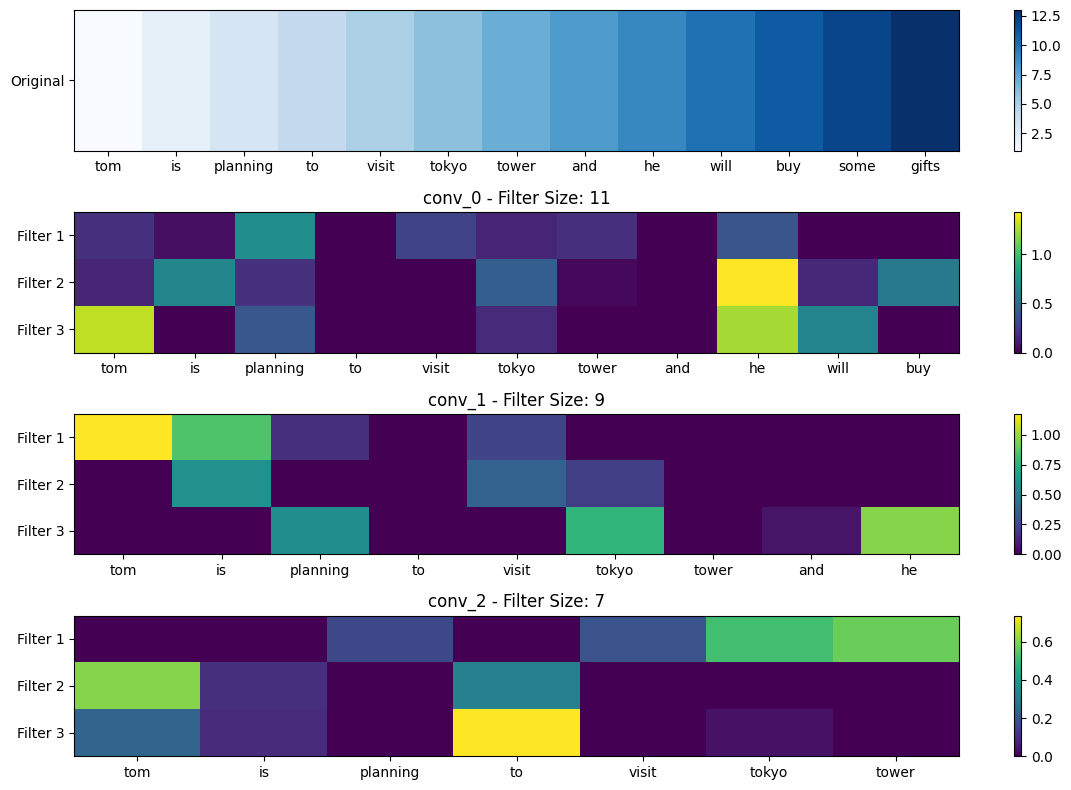


Explanation:
1. The original sentence has a long-term dependency between 'Tom' and 'he'
2. In the feature maps, you can see how different filter sizes capture different contexts
3. Larger filters (5, 7) can capture relationships between distant words
4. This demonstrates how CNNs can help with long-term dependencies

Hierarchical CNN concept:
- First layer captures local patterns (A1, A2, etc.)
- Stacking CNNs (as in your slides with B1, C1, D1 layers) further reduces the distance
- With enough layers, the model can directly relate 'Tom' and 'he'


In [43]:
# Visualize how CNN processes this sentence
print("\nVisualizing CNN feature maps...")
visualize_feature_maps(model, text_tensor, VOCAB_SIZE, idx_to_word)

# Explanation
print("\nExplanation:")
print("1. The original sentence has a long-term dependency between 'Tom' and 'he'")
print("2. In the feature maps, you can see how different filter sizes capture different contexts")
print("3. Larger filters (5, 7) can capture relationships between distant words")
print("4. This demonstrates how CNNs can help with long-term dependencies")

# Showing the hierarchical CNN concept similar to the slides
print("\nHierarchical CNN concept:")
print("- First layer captures local patterns (A1, A2, etc.)")
print("- Stacking CNNs (as in your slides with B1, C1, D1 layers) further reduces the distance")
print("- With enough layers, the model can directly relate 'Tom' and 'he'")


Each cell value represents: How strongly a particular pattern was detected at that position in the text.
More specifically:

Rows (y-axis): Each row corresponds to a different convolutional filter.

Each filter learns to detect different linguistic patterns
One filter might activate for pronoun relationships
Another might activate for verb phrases
A third might activate for subject-object relationships


Columns (x-axis): Each column corresponds to a position in the text after applying the convolution.

For a filter of size 3, position 0 represents the processing of words 0-2
Position 1 represents words 1-3, and so on


Color intensity: The brightness/color value indicates activation strength.

Brighter/warmer colors (yellow, white) = Strong activation
Darker/cooler colors (blue, black) = Weak or no activation
Strong activation means the filter detected a pattern it was looking for


Example Interpretation
For example, in your sentence "Tom is planning to visit Tokyo Tower and he will buy some gifts":

If a cell at row 2, column 0 is bright, it means Filter 2 strongly detected a pattern in the first few words ("Tom is planning")
If a cell at row 1, column 7 is bright, it means Filter 1 strongly detected a pattern around "and he will"


Model Architecture:
TextCNN(
  (embedding): Embedding(14, 50)
  (convs): ModuleList(
    (0): Conv1d(50, 3, kernel_size=(3,), stride=(1,))
    (1): Conv1d(50, 3, kernel_size=(5,), stride=(1,))
    (2): Conv1d(50, 3, kernel_size=(7,), stride=(1,))
  )
  (fc): Linear(in_features=9, out_features=2, bias=True)
)


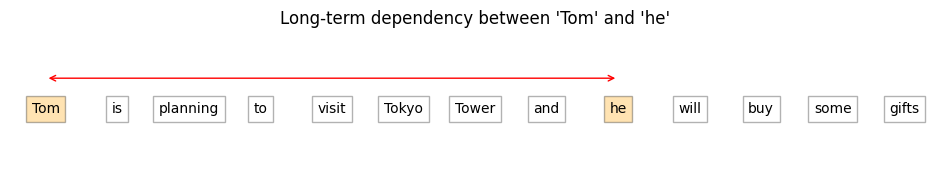


Detailed Layer-by-Layer Processing Results:

Embedding Layer Output: shape torch.Size([1, 50, 13])
First few values of embedding for 'Tom':
Word 'Tom' has index 10
tensor([ 0.1634, -0.1143, -0.3431, -0.5411,  2.0848, -0.1692, -0.8448,  0.4946,
        -1.1097,  0.6023], grad_fn=<SliceBackward0>)

Convolution Layer 1 (Filter Size: 3):
  - Output shape: torch.Size([1, 3, 11])
  - This layer processes 3 words at a time
  - Number of feature maps: 3
  - After pooling shape: torch.Size([1, 3])
    Window 1: tom is planning
      Max activation: 0.4646 (Filter 3)
    Window 3: planning to visit
      Max activation: 0.7705 (Filter 2)
    Window 6: tokyo tower and
      Max activation: 1.1264 (Filter 1)
    Window 7: tower and he
      Max activation: 1.1690 (Filter 2)
    Window 8: and he will
      Max activation: 0.4324 (Filter 2)
    Window 9: he will buy
      Max activation: 0.2894 (Filter 2)
    Window 11: buy some gifts
      Max activation: 0.5505 (Filter 1)

Convolution Layer 2 (Fi

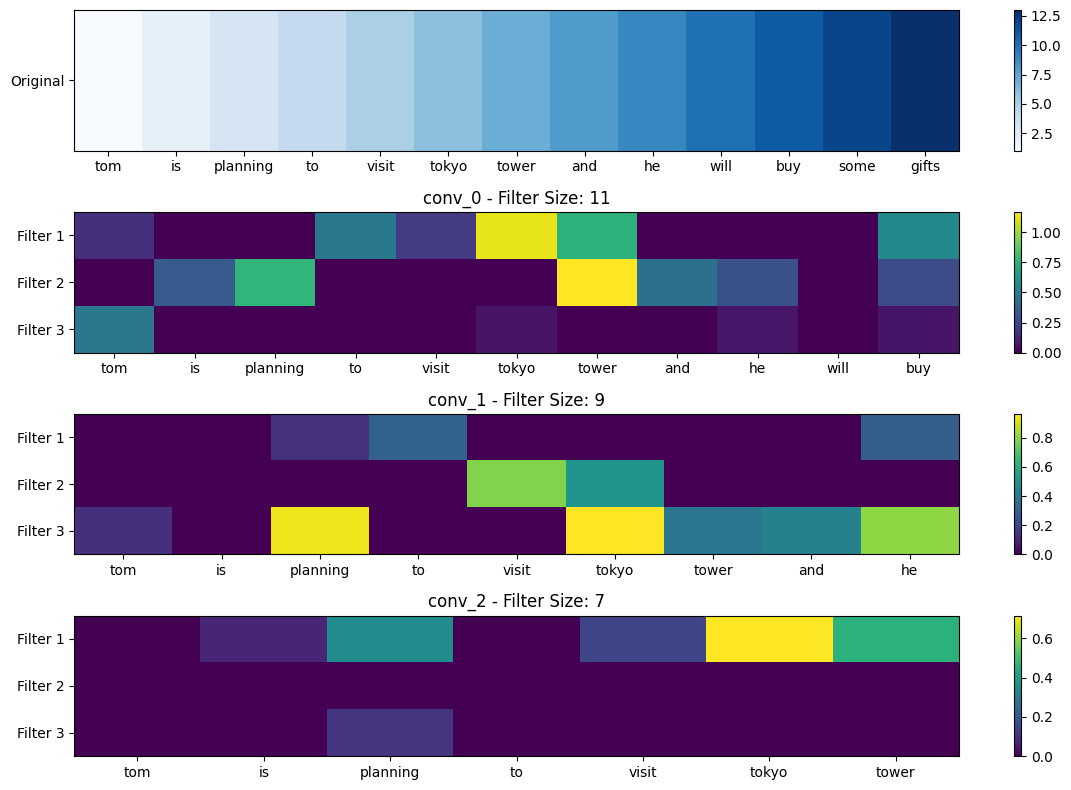


Explanation:
1. The original sentence has a long-term dependency between 'Tom' and 'he'
2. In the feature maps, you can see how different filter sizes capture different contexts
3. Larger filters (5, 7) can capture relationships between distant words
4. This demonstrates how CNNs can help with long-term dependencies

Hierarchical CNN concept:
- First layer captures local patterns (A1, A2, etc.)
- Stacking CNNs (as in your slides with B1, C1, D1 layers) further reduces the distance
- With enough layers, the model can directly relate 'Tom' and 'he'


In [44]:
# Demonstrate how CNN feature maps capture long-term dependencies
def run_demo():
    # Set parameters
    VOCAB_SIZE = len(vocab)
    EMBEDDING_DIM = 50
    NUM_FILTERS = 3
    FILTER_SIZES = [3, 5, 7]  # Different window sizes
    OUTPUT_DIM = 2  # Just for demonstration

    # Create model
    model = TextCNN(VOCAB_SIZE, EMBEDDING_DIM, NUM_FILTERS, FILTER_SIZES, OUTPUT_DIM)

    # Print model architecture
    print("\nModel Architecture:")
    print(model)

    # Create dataset with our example sentence
    dataset = TextDataset(example_sentence, vocab)
    text_tensor = dataset[0]

    # Visualize the original dependency
    visualize_dependencies(example_sentence, "Tom", "he")

    # Print detailed processing results for each layer
    print("\nDetailed Layer-by-Layer Processing Results:")

    # Get embeddings
    embedded = model.embedding(text_tensor.unsqueeze(0)).permute(0, 2, 1)
    print(f"\nEmbedding Layer Output: shape {embedded.shape}")
    print(f"First few values of embedding for 'Tom':")
    tom_idx = text_tensor[0].item()
    print(f"Word 'Tom' has index {tom_idx}")
    print(model.embedding(torch.tensor([tom_idx]))[0, :10])  # Print first 10 values

    # Process through each convolutional layer and print results
    for i, conv in enumerate(model.convs):
        conv_out = nn.functional.relu(conv(embedded))
        pooled = nn.functional.max_pool1d(conv_out, conv_out.shape[2]).squeeze(2)

        print(f"\nConvolution Layer {i+1} (Filter Size: {FILTER_SIZES[i]}):")
        print(f"  - Output shape: {conv_out.shape}")
        print(f"  - This layer processes {FILTER_SIZES[i]} words at a time")
        print(f"  - Number of feature maps: {NUM_FILTERS}")
        print(f"  - After pooling shape: {pooled.shape}")

        # Print the activation values for interesting tokens
        if FILTER_SIZES[i] <= len(tokenized_sentence):
            for token_idx in range(len(tokenized_sentence) - FILTER_SIZES[i] + 1):
                tokens_in_window = [idx_to_word[tokenized_sentence[token_idx + j]]
                                    for j in range(FILTER_SIZES[i])]
                # Format activation values
                activations = conv_out[0, :, token_idx].detach().numpy()
                max_activation = np.max(activations)
                max_filter = np.argmax(activations)

                # Only print for windows with significant activation or containing "Tom" or "he"
                if max_activation > 0.5 or "tom" in tokens_in_window or "he" in tokens_in_window:
                    print(f"    Window {token_idx+1}: {' '.join(tokens_in_window)}")
                    print(f"      Max activation: {max_activation:.4f} (Filter {max_filter+1})")

    # Final output
    cat = torch.cat([nn.functional.max_pool1d(nn.functional.relu(conv(embedded)),
                              nn.functional.relu(conv(embedded)).shape[2]).squeeze(2)
                     for conv in model.convs], dim=1)
    final_output = model.fc(cat)

    print(f"\nFinal Output Layer:")
    print(f"  - Combined feature vector shape: {cat.shape}")
    print(f"  - Final output shape: {final_output.shape}")

    # Visualize how CNN processes this sentence
    print("\nVisualizing CNN feature maps...")
    visualize_feature_maps(model, text_tensor, VOCAB_SIZE, idx_to_word)

    # Explanation
    print("\nExplanation:")
    print("1. The original sentence has a long-term dependency between 'Tom' and 'he'")
    print("2. In the feature maps, you can see how different filter sizes capture different contexts")
    print("3. Larger filters (5, 7) can capture relationships between distant words")
    print("4. This demonstrates how CNNs can help with long-term dependencies")

    # Showing the hierarchical CNN concept similar to the slides
    print("\nHierarchical CNN concept:")
    print("- First layer captures local patterns (A1, A2, etc.)")
    print("- Stacking CNNs (as in your slides with B1, C1, D1 layers) further reduces the distance")
    print("- With enough layers, the model can directly relate 'Tom' and 'he'")

if __name__ == "__main__":
    run_demo()